In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.linear_model import LinearRegression

In [4]:
masterData = pd.DataFrame(columns=["timeRaw", "setpointRaw", "encoderRaw"])

# Test 5 contains 200 step changes in randomised intervals
masterData = pd.read_csv("servoTest5.txt")
masterData["timeRaw"] = masterData["timeRaw"].apply(lambda p: p.split("=")[1]).apply(float)
masterData["setpointRaw"] = masterData["setpointRaw"].apply(lambda p: p.split("=")[1]).apply(float)
masterData["encoderRaw"] = masterData["encoderRaw"].apply(lambda p: p.split("=")[1]).apply(float)
masterData

,timeRaw,setpointRaw,encoderRaw
0,3194.0,-1788.0,-1.0
1,3197.0,-1788.0,-1.0
2,3201.0,-1788.0,-2.0
3,3203.0,-1788.0,-3.0
4,3206.0,-1788.0,-5.0
...,...,...,...
201431,606596.0,1212.0,1214.0
201432,606599.0,1212.0,1214.0
201433,606602.0,1212.0,1214.0
201434,606605.0,1212.0,1214.0


In [5]:
masterData["Time"] = masterData["timeRaw"] / 1000 # ms => s
masterData["Setpoint"] = masterData["setpointRaw"] / 12 / 298 * 360 # counts => deg
masterData["Encoder"] = masterData["encoderRaw"] / 12 / 298 * 360 # counts => deg
masterData

,timeRaw,setpointRaw,encoderRaw,Time,Setpoint,Encoder
0,3194.0,-1788.0,-1.0,3.194,-180.000000,-0.100671
1,3197.0,-1788.0,-1.0,3.197,-180.000000,-0.100671
2,3201.0,-1788.0,-2.0,3.201,-180.000000,-0.201342
3,3203.0,-1788.0,-3.0,3.203,-180.000000,-0.302013
4,3206.0,-1788.0,-5.0,3.206,-180.000000,-0.503356
...,...,...,...,...,...,...
201431,606596.0,1212.0,1214.0,606.596,122.013423,122.214765
201432,606599.0,1212.0,1214.0,606.599,122.013423,122.214765
201433,606602.0,1212.0,1214.0,606.602,122.013423,122.214765
201434,606605.0,1212.0,1214.0,606.605,122.013423,122.214765


<AxesSubplot: xlabel='Time', ylabel='Setpoint'>

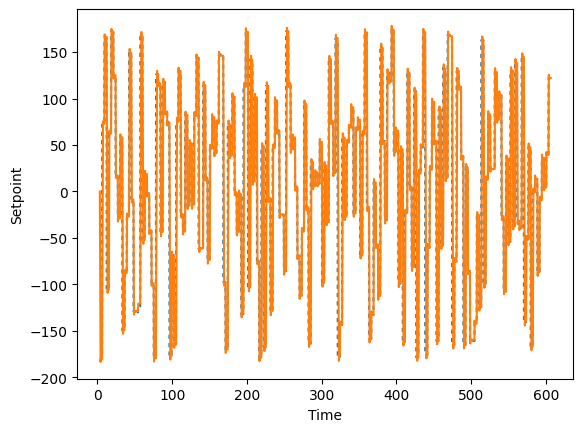

In [6]:
sns.lineplot(data=masterData, x="Time", y="Setpoint", dashes=(2, 2))
sns.lineplot(data=masterData, x="Time", y="Encoder")

In [7]:
masterData["eSmoothed"] = masterData["Encoder"].rolling(100).mean()

masterData["eVel"] = masterData["eSmoothed"].diff() / masterData["Time"].diff()
masterData["eVelSmoothed"] = masterData["eVel"].rolling(100).mean()

masterData["eAcc"] = masterData["eVelSmoothed"].diff() / masterData["Time"].diff()
masterData["eAccSmoothed"] = masterData["eAcc"].rolling(100).mean()

In [8]:
masterData["cycleI"] = masterData["Setpoint"].shift().ne(masterData["Setpoint"]).cumsum().shift(-100)

tg = masterData.groupby("cycleI")
trials = []
for name, t in tg:
    step_index = t.index[t["Setpoint"].ne(t["Setpoint"].shift())]

    if len(step_index) != 2:
        continue
    
    step_index = step_index[1]

    step_time = t["Time"][step_index]
    t["Time"] = t["Time"].sub(step_time) # set time = 0 on the step change

    t = t.drop(columns=["cycleI"])
    t.set_index("Time")

    trials.append(t)

len(trials)

200

[Text(0, 0.5, 'Angle')]

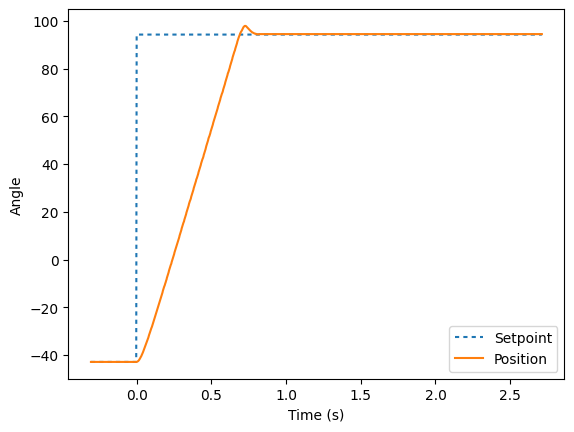

In [9]:
a = sns.lineplot(data=trials[90], x="Time", y="Setpoint", dashes=(2, 2), label="Setpoint")
sns.lineplot(data=trials[90], x="Time", y="Encoder", label="Position")
a.set(xlabel="Time (s)")
a.set(ylabel="Angle")

[Text(0, 0.5, '')]

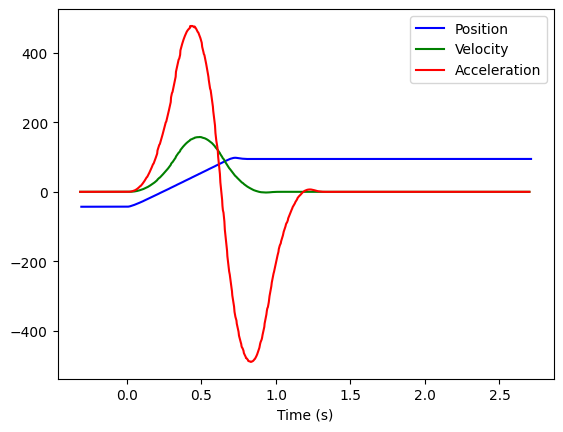

In [10]:
sns.lineplot(data=trials[90], x="Time", y="Encoder", label="Position", color="b")
a = sns.lineplot(data=trials[10], x="Time", y="eVelSmoothed", color="g", label="Velocity")
a.set(xlabel="Time (s)")
a.set(ylabel="")
b = sns.lineplot(data=trials[10], x="Time", y="eAccSmoothed", color="r", label="Acceleration")
b.set(ylabel="")

In [11]:
def calcResponseTime(t: pd.DataFrame):
    isSteady = (t["eVelSmoothed"] - 0).abs() < 1e-3

    steadyChangePoints = t.index[isSteady.shift().ne(isSteady)]

    return t["Time"][steadyChangePoints[-1]]

def calcPositioningError(t: pd.DataFrame, responseTime):
    positioningError = t["Setpoint"] - t["Encoder"]
    steadyPeriod = t["Time"] > responseTime
    croppedRegion = positioningError[steadyPeriod]

    return abs(croppedRegion.mean())

def calcOvershoot(t: pd.DataFrame, responseTime):
    # We assume that the overshoot will always be the extreme closer to the final steady state - this might noy be if we dramatically overshoot

    steadyStatePosition = t["Setpoint"][t["Time"] > responseTime].mean()

    maxValue = t["Encoder"].max()
    minValue = t["Encoder"].min()

    maxValueDist = abs(maxValue - steadyStatePosition)
    minValueDist = abs(minValue - steadyStatePosition)

    return min(maxValueDist, minValueDist)

In [12]:
responseTimes = []
overunderSteadyState = []
overshoots = []
stepSizes = []

for i, t in enumerate(trials):
    trialStepSize = t["Setpoint"].max() - t["Setpoint"].min()
    trialResponseTime = calcResponseTime(t)
    trialSteadyStateError = calcPositioningError(t, trialResponseTime)
    trialOvershoot = calcOvershoot(t, trialResponseTime)

    stepSizes.append(trialStepSize)
    responseTimes.append(trialResponseTime)
    overunderSteadyState.append(trialSteadyStateError)
    overshoots.append(trialOvershoot)

trialData = pd.DataFrame({
    "Step Change": stepSizes,
    "Response Time": responseTimes,
    "Steady State Error": overunderSteadyState,
    "Overshoot": overshoots
})

In [13]:
# This metric is not that meaningful for a ranomised step size - really I need to correlate this anaginst the step size
trialData["Response Time"].mean(), trialData["Response Time"].std()

(1.2798449999999986, 0.46509755930703994)

In [14]:
reg = LinearRegression().fit(trialData["Step Change"].values.reshape((-1, 1)), trialData["Response Time"].values)

(reg.coef_[0], reg.intercept_, reg.score(trialData["Step Change"].values.reshape((-1, 1)), trialData["Response Time"].values))

(0.005385958113485516, 0.6596699969170859, 0.8777936608259599)

<AxesSubplot: xlabel='Step Change', ylabel='Response Time'>

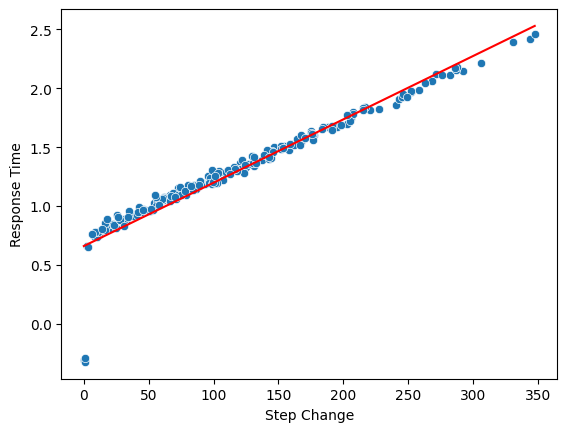

In [15]:
sns.scatterplot(x=trialData["Step Change"], y=trialData["Response Time"])
sns.lineplot(x=trialData["Step Change"], y=reg.predict(trialData["Step Change"].values.reshape((-1, 1))), color="r")

In [16]:
trialData["Steady State Error"].mean(), trialData["Steady State Error"].std()

(0.4164132510491991, 0.38856074440964683)

<AxesSubplot: xlabel='Step Change', ylabel='Steady State Error'>

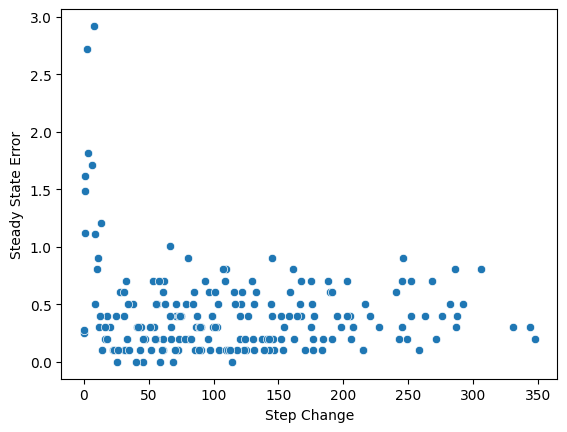

In [17]:
sns.scatterplot(x=trialData["Step Change"], y=trialData["Steady State Error"],)

In [18]:
trialData["Overshoot"].mean(), trialData["Overshoot"].std()

(3.5331917745391315, 0.4653132103196978)

<AxesSubplot: xlabel='Step Change', ylabel='Overshoot'>

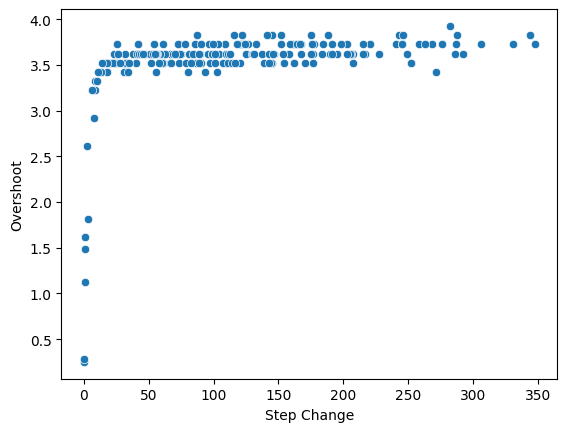

In [19]:
sns.scatterplot(x=trialData["Step Change"], y=trialData["Overshoot"],)